In [7]:
from datetime import datetime
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pylab import rcParams

# set maximum display rows as 200
pd.set_option('display.max_rows', 200)

plt.style.use('ggplot') # use ggplot styling
# displays graphs in the notebook
%matplotlib inline

In [8]:
# read data cloud
df = pd.read_csv('sonos_all_data-6m\sonoff_gutenberg_dump_2019-08-01-2020-06-08.csv')
# convert epoch time to datetime

df['time'] = pd.to_datetime(df['time']/1000000000,unit='s')
df.head(10)

,name,time,mean_power,mean_current,mean_voltage
0,mqtt_consumer,2019-08-01 00:00:00,NaN,NaN,NaN
1,mqtt_consumer,2019-08-01 00:00:10,NaN,NaN,NaN
2,mqtt_consumer,2019-08-01 00:00:20,NaN,NaN,NaN
3,mqtt_consumer,2019-08-01 00:00:30,NaN,NaN,NaN
4,mqtt_consumer,2019-08-01 00:00:40,NaN,NaN,NaN
5,mqtt_consumer,2019-08-01 00:00:50,NaN,NaN,NaN
6,mqtt_consumer,2019-08-01 00:01:00,NaN,NaN,NaN
7,mqtt_consumer,2019-08-01 00:01:10,NaN,NaN,NaN
8,mqtt_consumer,2019-08-01 00:01:20,NaN,NaN,NaN
9,mqtt_consumer,2019-08-01 00:01:30,NaN,NaN,NaN


In [9]:
df=df.set_index(df['time'])['2019-12-23 00:00:00' :'2020-06-07 23:59:50']
df=df[['time','mean_power']]
df.head()

,time,mean_power
time,,
2019-12-23 00:00:00,2019-12-23 00:00:00,55.0
2019-12-23 00:00:10,2019-12-23 00:00:10,55.0
2019-12-23 00:00:20,2019-12-23 00:00:20,55.0
2019-12-23 00:00:30,2019-12-23 00:00:30,55.0
2019-12-23 00:00:40,2019-12-23 00:00:40,55.0


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1451520 entries, 2019-12-23 00:00:00 to 2020-06-07 23:59:50
Data columns (total 8 columns):
time          1451520 non-null datetime64[ns]
mean_power    1388660 non-null float64
weekofyear    1451520 non-null int64
day_name      1451520 non-null int64
hour          1451520 non-null int64
mins          1451520 non-null int64
day_type      1451520 non-null object
kWh           1388660 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4), object(1)
memory usage: 99.7+ MB


In [11]:
# prepare data 
df['time'] = pd.to_datetime(df['time'])
df['weekofyear']=df['time'].dt.week
df['day_name']=df['time'].dt.weekday
df['hour']=df['time'].dt.hour
df['mins']=df['time'].dt.minute

# prepare weekday, weekend, and holiday columns
df['day_type'] = df['day_name'].apply(lambda x: 'weekday' if x <5 else 'weekend')



df['weekofyear']=df['weekofyear'].apply(lambda x:-2 if x==51 else (-1 if x==52 else x) )
df['kWh']=df['mean_power']/1000*1/60*1/60*10
# lockdown
df.loc[df.weekofyear >12, 'day_type'] = 'holiday'
# christmas eve
df.loc[(df.weekofyear== -1) & (df.day_name==1 ) ,'day_type']='holiday'
# christmas
df.loc[(df.weekofyear== -1) & (df.day_name==2 ) ,'day_type']='holiday'
# new year
df.loc[(df.weekofyear== 1) & (df.day_name==2 ) ,'day_type']='holiday'

C:\Users\User\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


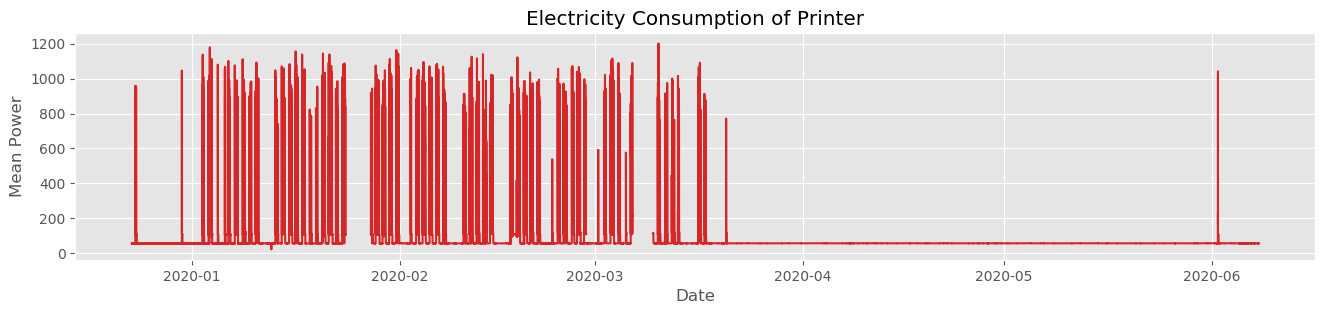

In [12]:
# Draw Plot
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Mean Power', dpi=100):
    plt.figure(figsize=(16,3), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

plot_df(df, x=df['time'], y=df['mean_power'], title='Electricity Consumption of Printer')

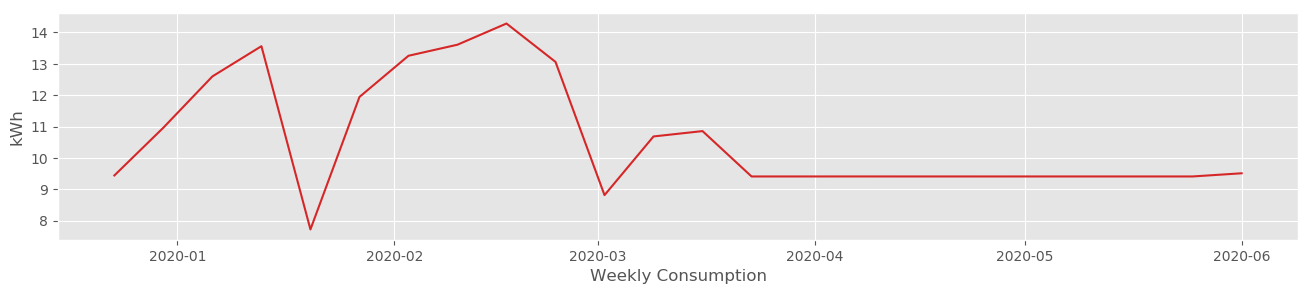

In [13]:
# prepare summed weekly, daily, and hourly patterns
week = pd.DataFrame({'Week_kWh' : (df.groupby( ['weekofyear'])['kWh'].sum())}).reset_index()
# the date is made here by using date_range
week['week_date'] = pd.date_range(start="12/17/2019", end="06/07/2020", freq='W-MON')
plot_df(week, x=week.week_date, y=week.Week_kWh, xlabel='Weekly Consumption',ylabel='kWh', title='') 

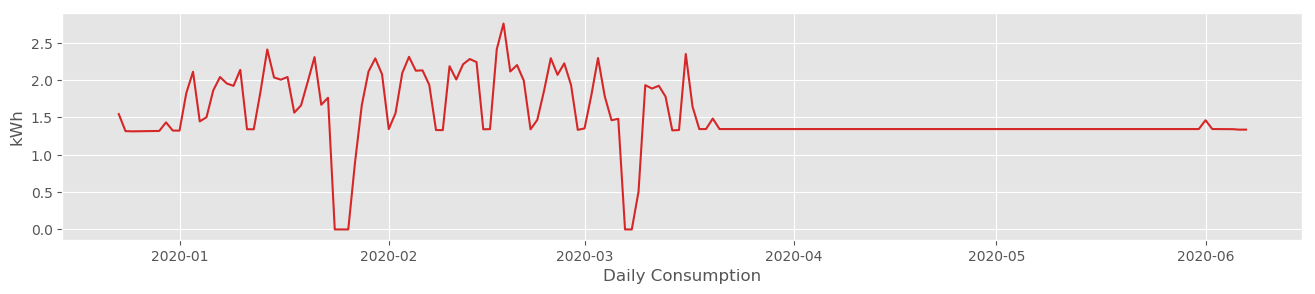

In [14]:
# prepare summed weekly, daily, and hourly patterns
day = pd.DataFrame({'day_kWh' : (df.groupby( ['weekofyear','day_name'])['kWh'].sum())}).reset_index()
day['day_date'] = pd.date_range(start="12/23/2019", end="06/07/2020", freq='D')
plot_df(day, x=day.day_date, y=day.day_kWh, xlabel='Daily Consumption',ylabel='kWh', title='') 

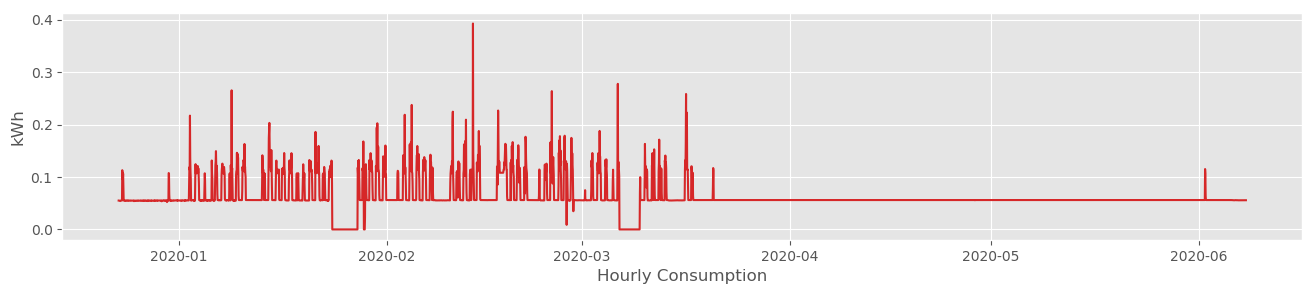

In [15]:
# prepare summed weekly, daily, and hourly patterns
hour = pd.DataFrame({'hour_kWh' : (df.groupby( ['weekofyear','day_name','hour'])['kWh'].sum())}).reset_index()
hour['hour_index'] = pd.date_range(start="12/23/2019", end="06/07/2020 23:00:00", freq='H')
plot_df(hour, x=hour.hour_index, y=hour.hour_kWh, xlabel='Hourly Consumption',ylabel='kWh', title='') 

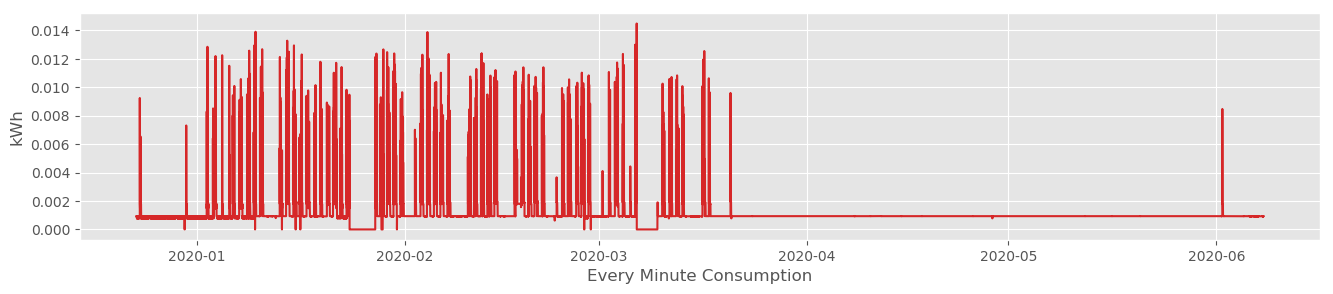

In [16]:
# prepare summed weekly, daily, and hourly patterns
minute = pd.DataFrame({'minute_kWh' : (df.groupby( ['weekofyear','day_name','hour','mins'])['kWh'].sum())}).reset_index()
minute['mins_index'] = pd.date_range(start="12/23/2019", end="06/07/2020 23:59:00", freq='T')
plot_df(minute, x=minute.mins_index, y=minute.minute_kWh, xlabel='Every Minute Consumption',ylabel='kWh', title='') 

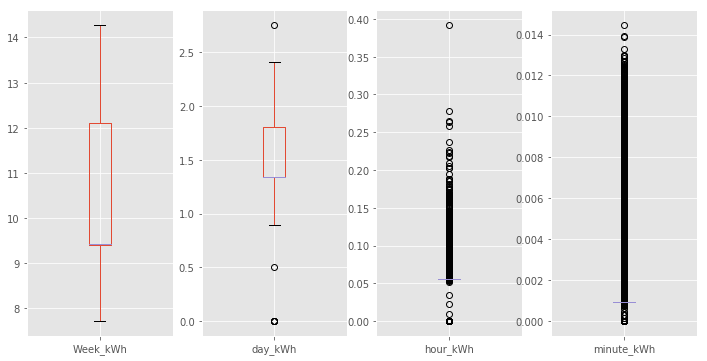

In [17]:
# boxplots of power consumption 
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 4, 1)
weekbp = week.boxplot(column=['Week_kWh'])

plt.subplot(1, 4, 2)
daybp = day.boxplot(column=['day_kWh'])

plt.subplot(1, 4, 3)
hourbp = hour.boxplot(column=['hour_kWh'])

plt.subplot(1, 4, 4)
minsbp = minute.boxplot(column=['minute_kWh'])

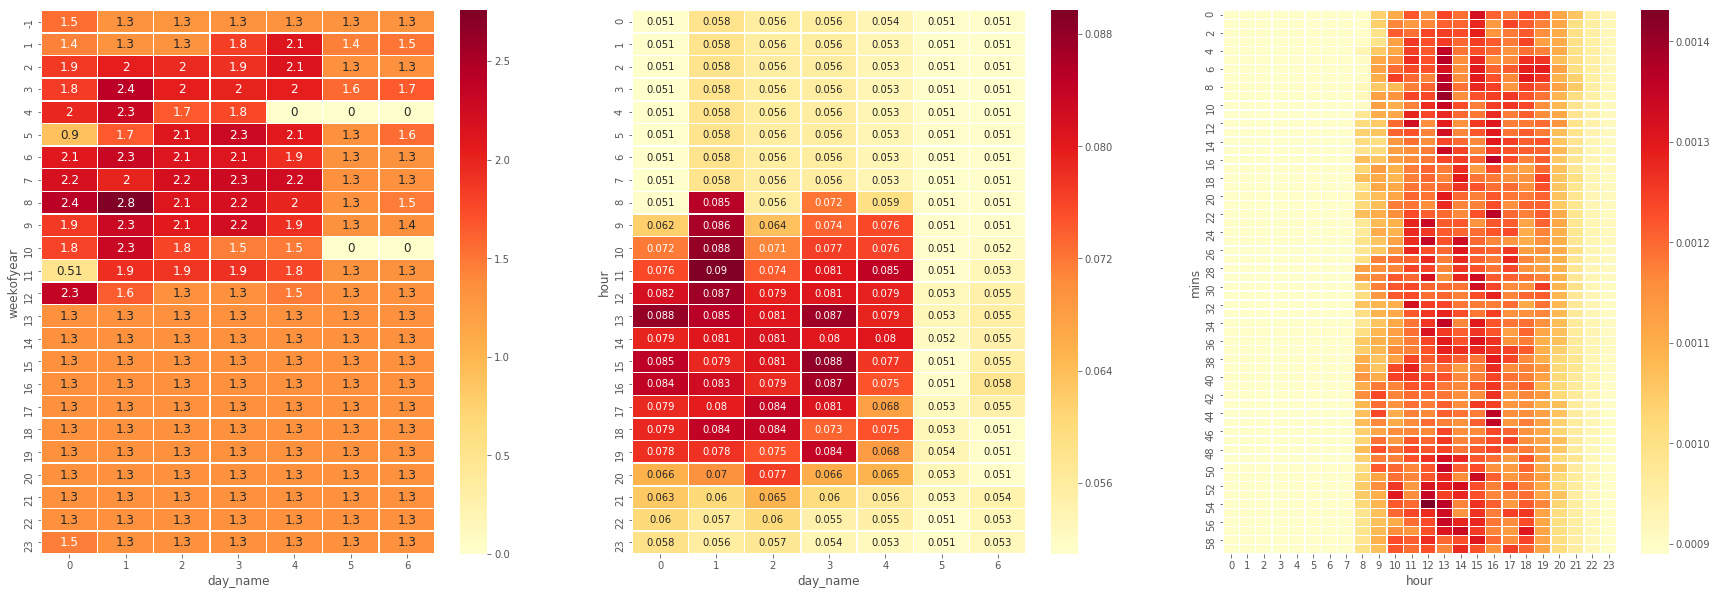

In [18]:
# heatmap of different period time trend

fig = plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
# plot week and day heatmap  
day_pi = day.pivot("weekofyear", "day_name", "day_kWh")
ax0 = sns.heatmap(day_pi, linewidth=0.5, annot=True,cmap="YlOrRd",annot_kws={"size": 12})

plt.subplot(1, 3, 2)
# plot day and hour heatmap  
hour_pi =hour.reset_index().pivot_table("hour_kWh", "hour","day_name" )
ax1 = sns.heatmap(hour_pi,linewidth=0.5 ,cmap="YlOrRd",annot=True,annot_kws={"size": 10})

plt.subplot(1, 3, 3)
# plot hour and minute heatmap
mins_pi =minute.reset_index().pivot_table( "minute_kWh", "mins","hour")
ax2 = sns.heatmap(mins_pi,linewidth=0.5 ,cmap="YlOrRd",annot=False,annot_kws={"size": 8})

In [107]:
df['kWh'].fillna(method='ffill',limit=251, inplace=True)

In [109]:
# assum missing value would be as normal pattern before lockdown, so replace the value same as the week before 
import math
for i in range(0,725760):
    if math.isnan(float(df['kWh'][i])):
        df['kWh'][i]= df['kWh'][i-60480]

C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [111]:
# assum missing value would be as normal pattern after lockdown, so replace the value same as the week before 
for i in range(725760,len(df)):
    if math.isnan(float(df['kWh'][i])):
        df['kWh'][i]= df['kWh'][i+60480]

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1451520 entries, 2019-12-23 00:00:00 to 2020-06-07 23:59:50
Data columns (total 7 columns):
mean_power    1388660 non-null float64
weekofyear    1451520 non-null int64
day_name      1451520 non-null int64
hour          1451520 non-null int64
mins          1451520 non-null int64
day_type      1451520 non-null object
kWh           1451520 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 88.6+ MB


In [130]:
df1=df[['mean_power','weekofyear','day_name','hour','mins','day_type','kWh']]
# using sqlite as the database 
from sqlalchemy import create_engine
engine = create_engine('sqlite:///dissertation.db', echo=True) #set the database name as jba.db
sqlite_connection = engine.connect()
sqlite_table = "printer"       #set the table name as rainfall_data
df1.to_sql(sqlite_table, sqlite_connection, if_exists='replace')  # import dataframe to sqlite

2020-07-27 06:52:09,673 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2020-07-27 06:52:09,679 INFO sqlalchemy.engine.base.Engine ()
2020-07-27 06:52:09,682 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2020-07-27 06:52:09,683 INFO sqlalchemy.engine.base.Engine ()
2020-07-27 06:52:11,559 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("printer")
2020-07-27 06:52:11,561 INFO sqlalchemy.engine.base.Engine ()
2020-07-27 06:52:11,567 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("printer")
2020-07-27 06:52:11,568 INFO sqlalchemy.engine.base.Engine ()
2020-07-27 06:52:11,574 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2020-07-27 06:52:11,576 INFO sqlalchemy.engine.base.Engine ()
2020-07-27 06:52:11,582 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("printer")
2020-07-27 06:52:11,584 INFO sqlalchemy.engine.base.Engine ()
202

In [118]:
sqlite_connection.close() # close the connection

In [119]:
df_engineering= df.copy()

In [152]:
week.describe()

,weekofyear,Week_kWh
count,24.000000,24.000000
mean,11.458333,10.599488
std,7.144345,1.850945
min,-1.000000,7.718636
25%,5.750000,9.408063
50%,11.500000,9.424440
75%,17.250000,12.107467
max,23.000000,14.286021


In [153]:
day.describe()

,weekofyear,day_name,day_kWh
count,168.000000,168.000000,168.000000
mean,11.458333,3.000000,1.514213
std,7.014830,2.005979,0.443198
min,-1.000000,0.000000,0.000000
25%,5.750000,1.000000,1.344004
50%,11.500000,3.000000,1.344012
75%,17.250000,5.000000,1.800039
max,23.000000,6.000000,2.757298


In [120]:
df_engineering['id']=np.repeat(range(1,4033),360)

In [123]:
df_engineering=df_engineering[['id','kWh']]
df_tsfel = df_engineering[['kWh']]

In [151]:
import tsfel
#from tsfresh import extract_relevant_features
cfg = tsfel.get_features_by_domain()
X_train = tsfel.time_series_features_extractor(cfg, df_tsfel, fs=10, window_splitter=True, window_size=360)
#from tsfresh.feature_extraction import ComprehensiveFCParameters 
#from tsfresh import extract_features 
#settings = ComprehensiveFCParameters() 
#extracted_features = extract_features(df_engineering,column_id='id',column_sort='time')

ImportError: cannot import name 'prod' from 'scipy._lib._util' (C:\Users\User\Anaconda3\lib\site-packages\scipy\_lib\_util.py)

In [115]:
subset=df['2020-01-23 00:00:00':'2020-01-25 23:59:50']
subset
#subset.loc[subset['kWh'].isna()]

,time,mean_power,weekofyear,day_name,hour,mins,day_type,kWh
time,,,,,,,,
2020-01-23 00:00:00,2020-01-23 00:00:00,56.0,4,3,0,0,weekday,0.000156
2020-01-23 00:00:10,2020-01-23 00:00:10,56.0,4,3,0,0,weekday,0.000156
2020-01-23 00:00:20,2020-01-23 00:00:20,55.5,4,3,0,0,weekday,0.000154
2020-01-23 00:00:30,2020-01-23 00:00:30,56.0,4,3,0,0,weekday,0.000156
2020-01-23 00:00:40,2020-01-23 00:00:40,56.0,4,3,0,0,weekday,0.000156
2020-01-23 00:00:50,2020-01-23 00:00:50,56.0,4,3,0,0,weekday,0.000156
2020-01-23 00:01:00,2020-01-23 00:01:00,56.0,4,3,0,1,weekday,0.000156
2020-01-23 00:01:10,2020-01-23 00:01:10,56.0,4,3,0,1,weekday,0.000156
2020-01-23 00:01:20,2020-01-23 00:01:20,56.0,4,3,0,1,weekday,0.000156


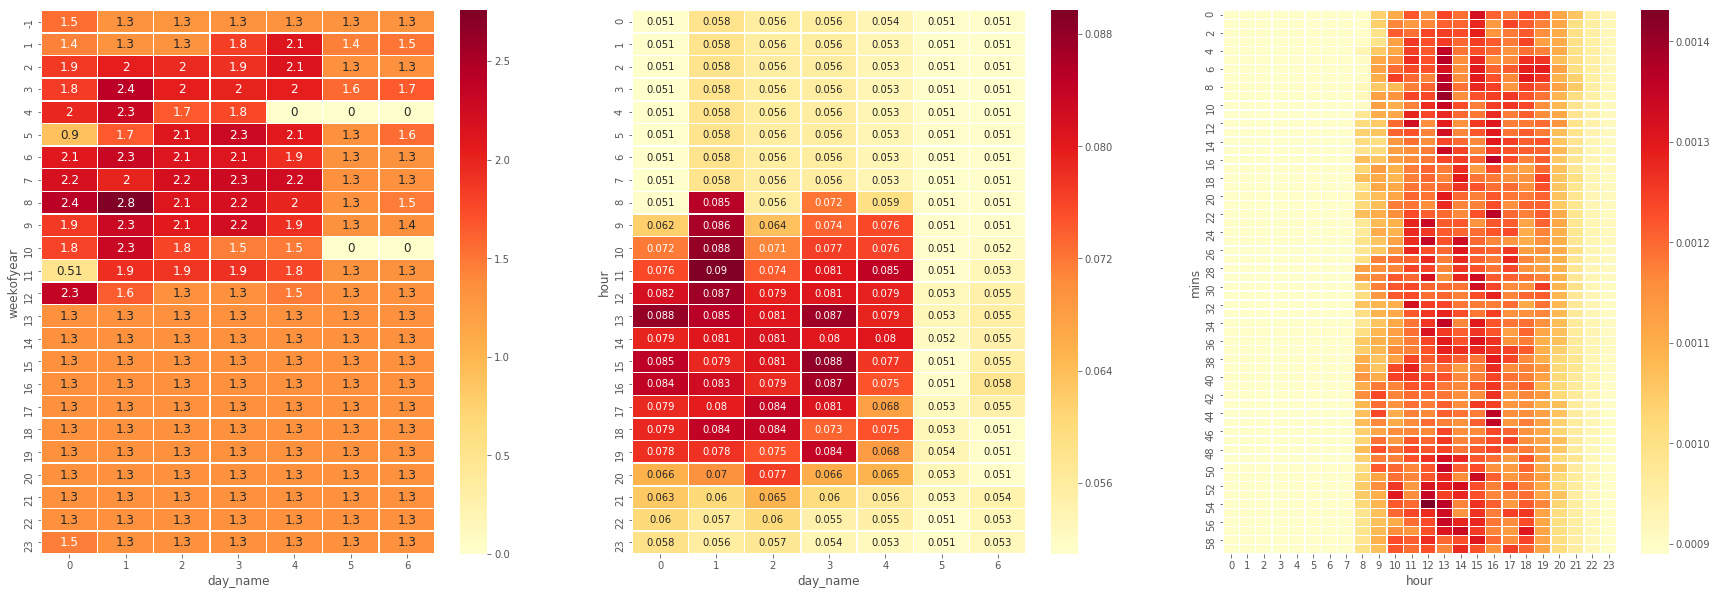

In [114]:
# heatmap of different period time trend

fig = plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
# plot week and day heatmap  
day_pi = day.pivot("weekofyear", "day_name", "day_kWh")
ax0 = sns.heatmap(day_pi, linewidth=0.5, annot=True,cmap="YlOrRd",annot_kws={"size": 12})

plt.subplot(1, 3, 2)
# plot day and hour heatmap  
hour_pi =hour.reset_index().pivot_table("hour_kWh", "hour","day_name" )
ax1 = sns.heatmap(hour_pi,linewidth=0.5 ,cmap="YlOrRd",annot=True,annot_kws={"size": 10})

plt.subplot(1, 3, 3)
# plot hour and minute heatmap
mins_pi =minute.reset_index().pivot_table( "minute_kWh", "mins","hour")
ax2 = sns.heatmap(mins_pi,linewidth=0.5 ,cmap="YlOrRd",annot=False,annot_kws={"size": 8})

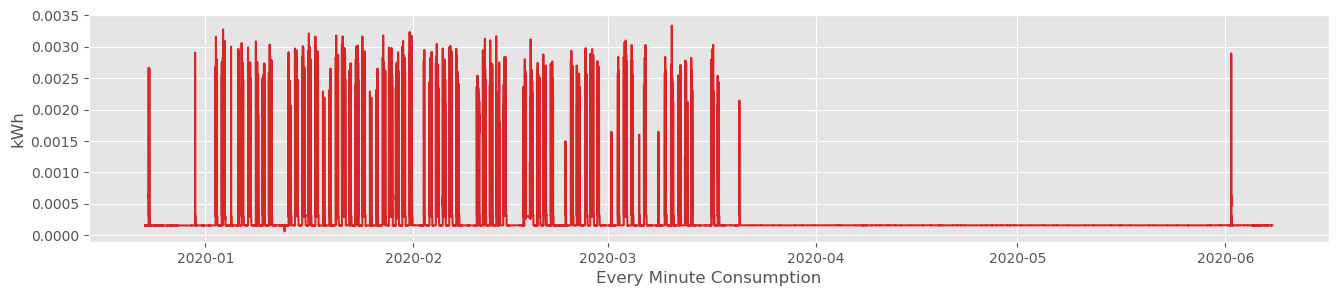

In [116]:
plot_df(df, x=df.index, y=df.kWh, xlabel='Every Minute Consumption',ylabel='kWh', title='') 

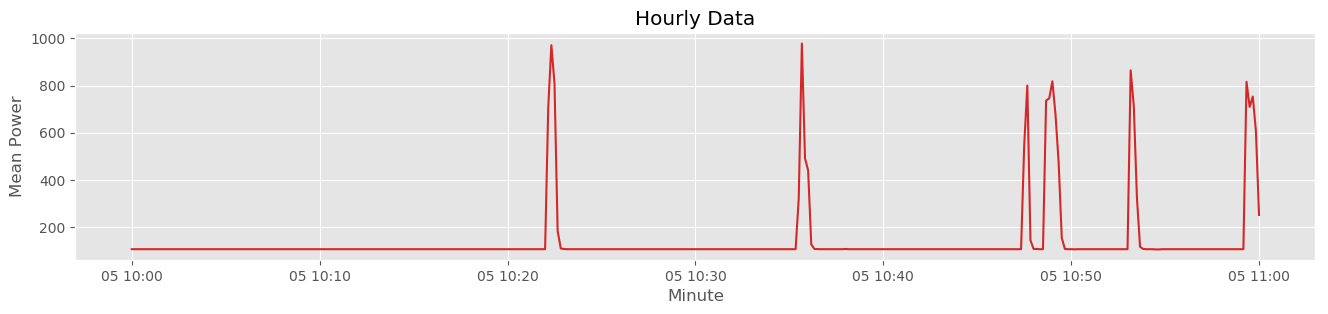

In [6]:
hourly_df = df.set_index(df['time'])['2020-02-05 10:00:00' :'2020-02-05 11:00:00']
plot_df(hourly_df, x=hourly_df.time, y=hourly_df.mean_power, xlabel='Minute',ylabel='Mean Power', title='Hourly Data') 

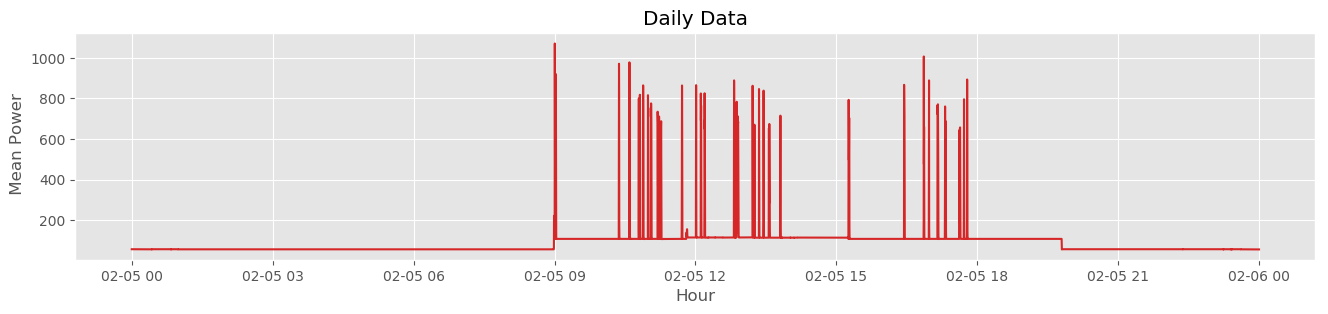

In [7]:
daily_df=df.set_index(df['time'])['2020-02-05 00:00:00' :'2020-02-05 23:59:50']

plot_df(daily_df, x=daily_df.time, y=daily_df.mean_power, xlabel='Hour',ylabel=' Mean Power', title='Daily Data') 

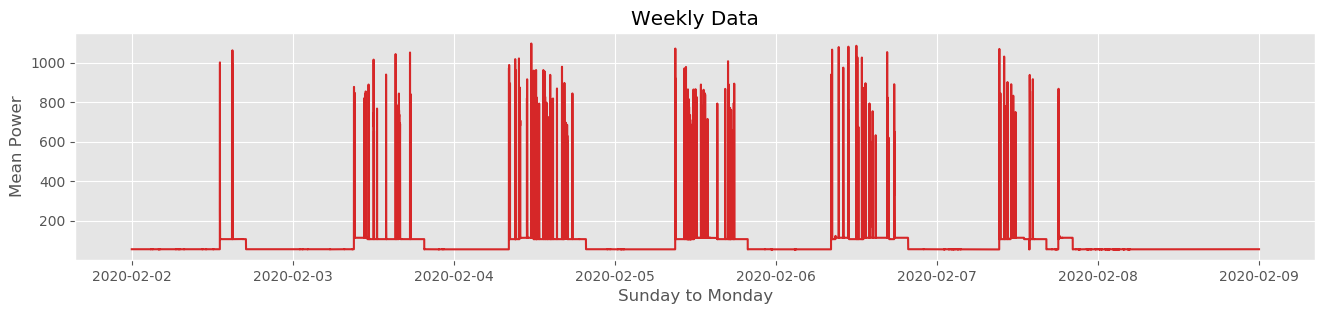

In [8]:
weekly_df=df.set_index(df['time'])['2020-02-02 00:00:00' :'2020-02-08 23:59:50']

plot_df(weekly_df, x=weekly_df.time, y=weekly_df.mean_power, xlabel='Sunday to Monday',ylabel='Mean Power', title='Weekly Data')

In [14]:
# prepare hour data
df['Hour']=df['time'].dt.hour

# prepare weekday, weekend, and holiday columns
df['day_type'] = df['day_name'].apply(lambda x: 'weekend' if (x == 'Sunday' or x == 'Saturday') else 'weekday')

df.loc[df['weekofyear']==4]

,index,name,time,mean_power,mean_current,mean_voltage,day_name,weekofyear,Hour,day_type
261168,1486080,mqtt_consumer,2020-01-20 00:00:00,55.0,0.497500,241.000000,Monday,4,0,weekday
261169,1486081,mqtt_consumer,2020-01-20 00:00:10,55.0,0.497500,241.000000,Monday,4,0,weekday
261170,1486082,mqtt_consumer,2020-01-20 00:00:20,55.0,0.497500,241.000000,Monday,4,0,weekday
261171,1486083,mqtt_consumer,2020-01-20 00:00:30,55.0,0.497000,241.000000,Monday,4,0,weekday
261172,1486084,mqtt_consumer,2020-01-20 00:00:40,55.5,0.497000,240.500000,Monday,4,0,weekday
261173,1486085,mqtt_consumer,2020-01-20 00:00:50,55.0,0.496500,241.000000,Monday,4,0,weekday
261174,1486086,mqtt_consumer,2020-01-20 00:01:00,55.0,0.496500,240.500000,Monday,4,0,weekday
261175,1486087,mqtt_consumer,2020-01-20 00:01:10,55.0,0.496500,240.000000,Monday,4,0,weekday
261176,1486088,mqtt_consumer,2020-01-20 00:01:20,55.5,0.497000,240.500000,Monday,4,0,weekday
261177,1486089,mqtt_consumer,2020-01-20 00:01:30,55.0,0.497000,241.000000,Monday,4,0,weekday


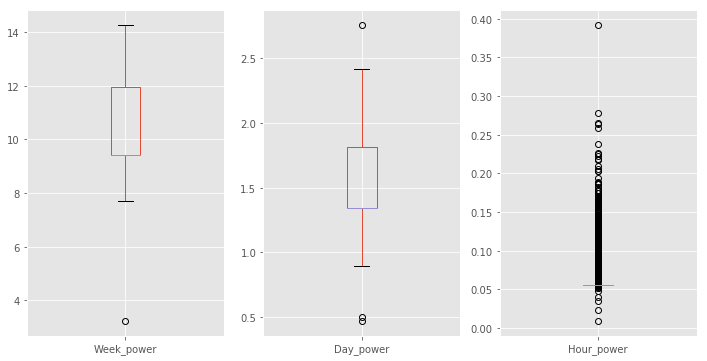

In [10]:
# boxplots of power consumption 
fig = plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
week = pd.DataFrame({'Week_power' : (df.groupby( ['weekofyear'])['mean_power'].sum()/1000*1/60*1/60*10)}).reset_index()

weekbp = week.boxplot(column=['Week_power'])

plt.subplot(1, 3, 2)
day = pd.DataFrame({'Day_power' : (df.groupby( ['weekofyear','day_name'])['mean_power'].sum()/1000*1/60*1/60*10)}).reset_index()
daybp = day.boxplot(column=['Day_power'])

plt.subplot(1, 3, 3)
hour = pd.DataFrame({'Hour_power' : (df.groupby( ['weekofyear','day_name','Hour'] )['mean_power'].sum()/1000*1/60*1/60*10)}).reset_index()
hourbp = hour.boxplot(column=['Hour_power'])

In [11]:
week.loc[week['Week_power']<4]

,weekofyear,Week_power
23,51,3.226497


In [13]:
day.loc[day['Day_power']<0.65]

,weekofyear,day_name,Day_power
66,11,Monday,0.505238
156,51,Friday,0.470382


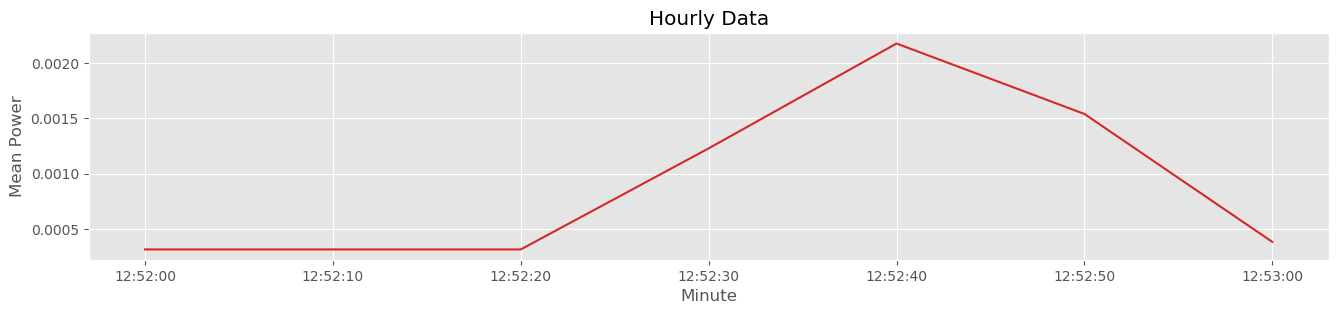

In [150]:
subset_min = df.set_index(df['time'])['2020-02-05 12:52:00' :'2020-02-05 12:53:00']
plot_df(subset_min, x=subset_min.index, y=subset_min.kWh, xlabel='Minute',ylabel='Mean Power', title='Hourly Data')

In [149]:
df


,mean_power,weekofyear,day_name,hour,mins,day_type,kWh,time
time,,,,,,,,
2019-12-23 00:00:00,55.0,-1,0,0,0,weekday,0.000153,2019-12-23 00:00:00
2019-12-23 00:00:10,55.0,-1,0,0,0,weekday,0.000153,2019-12-23 00:00:10
2019-12-23 00:00:20,55.0,-1,0,0,0,weekday,0.000153,2019-12-23 00:00:20
2019-12-23 00:00:30,55.0,-1,0,0,0,weekday,0.000153,2019-12-23 00:00:30
2019-12-23 00:00:40,55.0,-1,0,0,0,weekday,0.000153,2019-12-23 00:00:40
2019-12-23 00:00:50,55.0,-1,0,0,0,weekday,0.000153,2019-12-23 00:00:50
2019-12-23 00:01:00,55.0,-1,0,0,1,weekday,0.000153,2019-12-23 00:01:00
2019-12-23 00:01:10,55.0,-1,0,0,1,weekday,0.000153,2019-12-23 00:01:10
2019-12-23 00:01:20,55.0,-1,0,0,1,weekday,0.000153,2019-12-23 00:01:20


In [148]:
df['time'] = pd.date_range(start="12/23/2019 00:00:00", end="06/07/2020 23:59:50", freq='10S')